# Min-min Max-max

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix

from lightgbm import LGBMRegressor

from tqdm import tqdm_notebook
import pickle
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

D:\Programs\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
D:\Programs\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
D:\Programs\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
pd.set_option('max_columns', 100)

In [3]:
def area(box):
    return (box[2] - box[0]) * (box[3] - box[1])


def intersection_over_union(boxes):
    assert(len(boxes) == 8)
    boxA = boxes[:4].values
    boxB = boxes[4:].values
    
    boxAArea = area(boxA)
    boxBArea = area(boxB)
    
    if (boxAArea == 0 or boxBArea == 0):
        return 0
        
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)

    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [4]:
df_train_X = pd.read_csv('../Data/train_data.csv')
df_train_Y = pd.read_csv('../Data/train_answers.csv')

In [5]:
df_test = pd.read_csv('../Data/test_data.csv')

In [6]:
df_train_X.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax
0,1164,6132,62,656,276,803
1,1399,6132,184,662,235,740
2,1694,6132,63,648,272,830
3,916,6132,111,637,253,831
4,1621,6132,60,651,242,819


In [7]:
Xminl = list(df_train_X.head()['Xmin'].values)
X_useridl = list(df_train_X.head()['userId'].values)
Xminl_sort = [x for _,x in sorted(zip(Xminl, X_useridl), key=lambda pair: pair[0])]
Xminl_sort

[1621, 1164, 1694, 916, 1399]

In [8]:
a = [3,4,2,2,6]
b = [1000, 2000, 1500, 2500, 3000]
a_s = sorted(a)
b_s = [x for _,x in sorted(zip(a, b))]
print(a_s)
print(b_s)

[2, 2, 3, 4, 6]
[1500, 2500, 1000, 2000, 3000]


In [11]:
list(range(0, -2, -1))

[0, -1]

In [12]:
def getminids(X):
    flag = True
    for item in tqdm_notebook(X['itemId'].unique()):
        data = X[X['itemId'] == item]
        Xminl = list(data['Xmin'].values)
        Yminl = list(data['Ymin'].values)
        Xmaxl = list(data['Xmax'].values)
        Ymaxl = list(data['Ymax'].values)
        X_useridl = list(data['userId'].values)
        
        Xminl_s = sorted(Xminl)
        Yminl_s = sorted(Yminl)
        Xmaxl_s = sorted(Xmaxl)
        Ymaxl_s = sorted(Ymaxl)

        userid_Xmin = [x for _,x in sorted(zip(Xminl, X_useridl))]
        userid_Ymin = [x for _,x in sorted(zip(Yminl, X_useridl))]
        userid_Xmax = [x for _,x in sorted(zip(Xmaxl, X_useridl), reverse=True)]
        userid_Ymax = [x for _,x in sorted(zip(Ymaxl, X_useridl), reverse=True)]
        for i in range(0, -2, -1):
            data['Xmin'+str(i)] = Xminl_s[i]
            data['Ymin'+str(i)] = Yminl_s[i]
            data['Xmax'+str(i)] = Xmaxl_s[i]
            data['Ymax'+str(i)] = Ymaxl_s[i]

            data['userXmin'+str(i)] = userid_Xmin[i]
            data['userYmin'+str(i)] = userid_Ymin[i]
            data['userXmax'+str(i)] = userid_Xmax[i]
            data['userYmax'+str(i)] = userid_Ymax[i]

        if flag:
            dfrez = data.copy()
            flag = False
        else:
            dfrez = pd.concat([dfrez, data], axis=0)
    return dfrez
            

In [13]:
df_train_X = getminids(df_train_X)
# df_test = getminids(df_test)

HBox(children=(IntProgress(value=0, max=943), HTML(value='')))

In [14]:
with open('df_train_X.pickle', 'wb') as F:
    pickle.dump(df_train_X, F)

# with open('df_test.pickle', 'wb') as F:
#     pickle.dump(df_test, F)

In [55]:
df_train_X.head()

,userId,itemId,Xmin,Ymin,Xmax,Ymax,Xmin0,Ymin0,Xmax0,Ymax0,userXmin0,userYmin0,userXmax0,userYmax0,Xmin-1,Ymin-1,Xmax-1,Ymax-1,userXmin-1,userYmin-1,userXmax-1,userYmax-1
0,1164,6132,62,656,276,803,39,637,235,740,1092,916,1164,916,184,662,276,831,1399,1399,1399,1399
1,1399,6132,184,662,235,740,39,637,235,740,1092,916,1164,916,184,662,276,831,1399,1399,1399,1399
2,1694,6132,63,648,272,830,39,637,235,740,1092,916,1164,916,184,662,276,831,1399,1399,1399,1399
3,916,6132,111,637,253,831,39,637,235,740,1092,916,1164,916,184,662,276,831,1399,1399,1399,1399
4,1621,6132,60,651,242,819,39,637,235,740,1092,916,1164,916,184,662,276,831,1399,1399,1399,1399


In [56]:
X_pred = df_train_X.groupby('itemId').agg({'Xmin': [min, max, 'mean', 'std', 'median'],
                                           'Ymin': [min, max, 'mean', 'std', 'median'],
                                           'Xmax': [min, max, 'mean', 'std', 'median'],
                                           'Ymax': [min, max, 'mean', 'std', 'median'],
#                                            'Xmin0': [max],
#                                            'Xmin-1': [max],
                                           
#                                            'Ymin0': [max],
#                                            'Ymin-1': [max],
                                           
# #                                            'Xmax0': [max],
#                                            'Xmax-1': [max],
                                           
#                                            'Ymax0': [max],
#                                            'Ymax-1': [max],
                                           
                                           'userXmin0': [max],
                                           'userXmin-1': [max],
                                           
                                           'userYmin0': [max],
                                           'userYmin-1': [max],
                                           
                                           'userXmax0': [max],
                                           'userXmax-1': [max],
                                           
                                           'userYmax0': [max],
                                           'userYmax-1': [max],
#                                            'Xmin_id': 'max',
#                                            'Ymin_id': 'max',
#                                            'Xmax_id': 'max',
#                                            'Ymax_id': 'max',
                                           'userId': ['count']})

In [57]:
df_test.groupby('itemId').count().describe()

,userId,Xmin,Ymin,Xmax,Ymax
count,630.000000,630.000000,630.000000,630.000000,630.000000
mean,5.738095,5.738095,5.738095,5.738095,5.738095
std,2.548039,2.548039,2.548039,2.548039,2.548039
min,2.000000,2.000000,2.000000,2.000000,2.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000
50%,6.000000,6.000000,6.000000,6.000000,6.000000
75%,8.000000,8.000000,8.000000,8.000000,8.000000
max,14.000000,14.000000,14.000000,14.000000,14.000000


In [58]:
X_pred[('userId', 'count')].describe()

count    943.000000
mean       5.659597
std        2.681566
min        3.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       24.000000
Name: (userId, count), dtype: float64

In [59]:
X_pred = X_pred.merge(df_train_Y, on='itemId', how='inner')

In [60]:
# X_pred["iou"] = X_pred[[('Xmin', 'min'),('Ymin', 'min'), ('Xmax', 'max'), ('Ymax', 'max'), 'Xmin_true',\
#       'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [61]:
# X_pred['iou'].mean()

In [62]:
X_pred.head()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)","(Ymin, median)","(Xmax, min)","(Xmax, max)","(Xmax, mean)","(Xmax, std)","(Xmax, median)","(Ymax, min)","(Ymax, max)","(Ymax, mean)","(Ymax, std)","(Ymax, median)","(userXmin0, max)","(userXmin-1, max)","(userYmin0, max)","(userYmin-1, max)","(userXmax0, max)","(userXmax-1, max)","(userYmax0, max)","(userYmax-1, max)","(userId, count)",Xmin_true,Ymin_true,Xmax_true,Ymax_true
0,5,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,917.0,483,511,501.333333,15.885003,510.0,1160,1331,1248.666667,85.675745,1255.0,903,141,1723,141,903,141,1723,903,3,198,827,649,1340
1,10,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,559.0,402,427,416.333333,12.897028,420.0,852,858,855.333333,3.055050,856.0,903,1723,141,903,141,1723,903,141,3,26,605,433,847
2,13,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,603.0,561,621,596.666667,31.564748,608.0,950,981,966.666667,15.631165,969.0,141,903,141,1723,141,1723,1723,903,3,233,698,622,920
3,30,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,367.0,97,324,269.200000,97.497179,316.0,369,491,459.200000,51.363411,477.0,1565,1573,903,1565,1565,141,1508,141,5,61,368,329,530
4,32,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,560.0,126,388,256.166667,141.158658,254.0,624,884,756.833333,137.917971,759.5,366,141,141,903,141,903,366,141,6,30,536,328,813


### Прогнозирование отклонения

In [63]:
X_pred['Volume'] = (X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')]) *\
                    (X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')])
    
X_pred['Mean_Volume'] = (X_pred[('Xmax', 'mean')] - X_pred[('Xmin', 'mean')]) *\
                    (X_pred[('Ymax', 'mean')] - X_pred[('Ymin', 'mean')])
    
X_pred['Min_Volume'] = abs((X_pred[('Xmax', 'min')] - X_pred[('Xmin', 'max')]) *\
                    (X_pred[('Ymax', 'min')] - X_pred[('Ymin', 'max')]))
    
X_pred['X_Y_ratio'] = (X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')])/\
                            (X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')])
    
X_pred['X_length'] = X_pred[('Xmax', 'max')] - X_pred[('Xmin', 'min')]
X_pred['Y_length'] = X_pred[('Ymax', 'max')] - X_pred[('Ymin', 'min')]

X_pred['Diag_length'] = np.sqrt(X_pred['X_length']**2 + X_pred['Y_length']**2)

In [64]:
X_pred['X_Y_ratio'] = X_pred['X_Y_ratio'].replace(np.inf, 2)
X_pred.fillna(1, inplace=True)

In [65]:
Xmin_dtarg = X_pred['Xmin_true'] - X_pred[('Xmin', 'min')]
Ymin_dtarg = X_pred['Ymin_true'] - X_pred[('Ymin', 'min')]
Xmax_dtarg = X_pred['Xmax_true'] - X_pred[('Xmax', 'max')]
Ymax_dtarg = X_pred['Ymax_true'] - X_pred[('Ymax', 'max')]

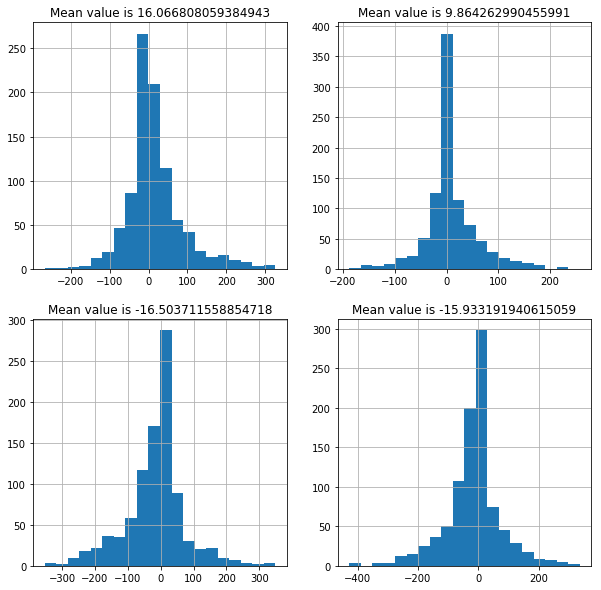

In [66]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
Xmin_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Xmin_dtarg.mean()));

plt.subplot(2, 2, 2)
Ymin_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Ymin_dtarg.mean()));

plt.subplot(2, 2, 3)
Xmax_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Xmax_dtarg.mean()));

plt.subplot(2, 2, 4)
Ymax_dtarg.hist(bins=20)
plt.title('Mean value is {}'.format(Ymax_dtarg.mean()));

In [67]:
X_pred.head()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)","(Ymin, median)","(Xmax, min)","(Xmax, max)","(Xmax, mean)","(Xmax, std)","(Xmax, median)","(Ymax, min)","(Ymax, max)","(Ymax, mean)","(Ymax, std)","(Ymax, median)","(userXmin0, max)","(userXmin-1, max)","(userYmin0, max)","(userYmin-1, max)","(userXmax0, max)","(userXmax-1, max)","(userYmax0, max)","(userYmax-1, max)","(userId, count)",Xmin_true,Ymin_true,Xmax_true,Ymax_true,Volume,Mean_Volume,Min_Volume,X_Y_ratio,X_length,Y_length,Diag_length
0,5,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,917.0,483,511,501.333333,15.885003,510.0,1160,1331,1248.666667,85.675745,1255.0,903,141,1723,141,903,141,1723,903,3,198,827,649,1340,150120,104610.000000,64155,0.863309,360,417,550.898357
1,10,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,559.0,402,427,416.333333,12.897028,420.0,852,858,855.333333,3.055050,856.0,903,1723,141,903,141,1723,903,141,3,26,605,433,847,106145,96189.777778,86292,1.187291,355,299,464.140065
2,13,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,603.0,561,621,596.666667,31.564748,608.0,950,981,966.666667,15.631165,969.0,141,903,141,1723,141,1723,1723,903,3,233,698,622,920,219075,191652.333333,160648,1.509186,575,381,689.772426
3,30,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,367.0,97,324,269.200000,97.497179,316.0,369,491,459.200000,51.363411,477.0,1565,1573,903,1565,1565,141,1508,141,5,61,368,329,530,35742,16642.080000,162,1.876812,259,138,293.470612
4,32,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,560.0,126,388,256.166667,141.158658,254.0,624,884,756.833333,137.917971,759.5,366,141,141,903,141,903,366,141,6,30,536,328,813,229295,45790.000000,15540,0.626446,379,605,713.908958


In [68]:
# train_data = X_pred.drop(columns=['itemId', 'Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true', 'iou'], axis=1)
train_data = X_pred.drop(columns=['itemId', 'Xmin_true', 'Ymin_true', 'Xmax_true', 'Ymax_true'], axis=1)

In [69]:
train_data.columns

Index([      ('Xmin', 'min'),       ('Xmin', 'max'),      ('Xmin', 'mean'),
             ('Xmin', 'std'),    ('Xmin', 'median'),       ('Ymin', 'min'),
             ('Ymin', 'max'),      ('Ymin', 'mean'),       ('Ymin', 'std'),
          ('Ymin', 'median'),       ('Xmax', 'min'),       ('Xmax', 'max'),
            ('Xmax', 'mean'),       ('Xmax', 'std'),    ('Xmax', 'median'),
             ('Ymax', 'min'),       ('Ymax', 'max'),      ('Ymax', 'mean'),
             ('Ymax', 'std'),    ('Ymax', 'median'),  ('userXmin0', 'max'),
       ('userXmin-1', 'max'),  ('userYmin0', 'max'), ('userYmin-1', 'max'),
        ('userXmax0', 'max'), ('userXmax-1', 'max'),  ('userYmax0', 'max'),
       ('userYmax-1', 'max'),   ('userId', 'count'),              'Volume',
               'Mean_Volume',          'Min_Volume',           'X_Y_ratio',
                  'X_length',            'Y_length',         'Diag_length'],
      dtype='object')

In [70]:
class my_filter_model():
    def __init__(self, model, filtercond):
        self.model = model
        self.filtercond = filtercond
        
    def fit(self, X, y):
        X_train_filt = X.loc[self.filtercond]
        y_train_filt = y[self.filtercond]
        self.model.fit(X_train_filt, y_train_filt)
        return self.model
    
    def predict(self, X):
        return self.model.predict(X)

    def custom_cv(self, X, y, cv=4, dofilter=False):
        preds = np.zeros(X.shape[0])

        # Cross validation
        foldlen = X.shape[0] // cv
        for i in range(cv):
            if i == (cv-1):
                X_test = X.iloc[i*foldlen:, :]
                X_train = X.iloc[:i*foldlen, :]
                y_test = y[i*foldlen:]
                y_train = y[:i*foldlen]
                if dofilter:
                    train_cond = self.filtercond[:i*foldlen]
            else:          
                X_test = X.iloc[i*foldlen:(i+1)*foldlen, :]
                X_train = pd.concat([X.iloc[:i*foldlen, :], X.iloc[(i+1)*foldlen:, :]])
                y_test = y[i*foldlen:(i+1)*foldlen]
                y_train = pd.concat([y[:i*foldlen], y[(i+1)*foldlen:]])
                if dofilter:
                    train_cond = pd.concat([self.filtercond[:i*foldlen], self.filtercond[(i+1)*foldlen:]])
            if dofilter:
                X_train_filt = X_train.loc[train_cond]
                y_train_filt = y_train[train_cond]

            # Model fit predict
            self.model.fit(X_train_filt, y_train_filt)
            fold_preds = self.model.predict(X_test)
            if i == (cv-1):
                preds[i*foldlen:] = fold_preds
            else:
                preds[i*foldlen:(i+1)*foldlen] = fold_preds
        return preds

### Random Forest

In [71]:
model_Xmin = RandomForestRegressor(n_estimators=500, random_state=65)
preds_Xmin = cross_val_predict(model_Xmin, train_data, Xmin_dtarg, cv=4, n_jobs=-1)

In [72]:
model_Ymin = RandomForestRegressor(n_estimators=500, random_state=65)
preds_Ymin = cross_val_predict(model_Ymin, train_data, Ymin_dtarg, cv=4, n_jobs=-1)

In [73]:
model_Xmax = RandomForestRegressor(n_estimators=500, random_state=65)
preds_Xmax = cross_val_predict(model_Xmax, train_data, Xmax_dtarg, cv=4, n_jobs=-1)

In [74]:
model_Ymax = RandomForestRegressor(n_estimators=500, random_state=65)
preds_Ymax = cross_val_predict(model_Ymax, train_data, Ymax_dtarg, cv=4, n_jobs=-1)

## OR custom cv with filtering

In [19]:
with open ('filtercond.pikle', 'rb') as F:
    filtercond = pickle.load(F)

In [136]:
model = RandomForestRegressor(n_estimators=500, random_state=65, n_jobs=-1)
model_Xmin = my_filter_model(model, filtercond)
preds_Xmin = model_Xmin.custom_cv(train_data, Xmin_dtarg, dofilter=True)

In [137]:
model = RandomForestRegressor(n_estimators=500, random_state=65, n_jobs=-1)
model_Ymin = my_filter_model(model, filtercond)
preds_Ymin = model_Ymin.custom_cv(train_data, Ymin_dtarg, dofilter=True)

In [138]:
model = RandomForestRegressor(n_estimators=500, random_state=65, n_jobs=-1)
model_Xmax = my_filter_model(model, filtercond)
preds_Xmax = model_Xmax.custom_cv(train_data, Xmax_dtarg, dofilter=True)

In [139]:
model = RandomForestRegressor(n_estimators=500, random_state=65, n_jobs=-1)
model_Ymax = my_filter_model(model, filtercond)
preds_Ymax = model_Ymax.custom_cv(train_data, Ymax_dtarg, dofilter=True)

In [140]:
pd.Series(preds_Xmin).describe()

count    943.000000
mean      18.302757
std       36.184020
min     -115.472000
25%       -0.388000
50%       13.252000
75%       38.014000
max      147.840000
dtype: float64

In [51]:
train_data.columns

Index([      ('Xmin', 'min'),       ('Xmin', 'max'),      ('Xmin', 'mean'),
             ('Xmin', 'std'),    ('Xmin', 'median'),       ('Ymin', 'min'),
             ('Ymin', 'max'),      ('Ymin', 'mean'),       ('Ymin', 'std'),
          ('Ymin', 'median'),       ('Xmax', 'min'),       ('Xmax', 'max'),
            ('Xmax', 'mean'),       ('Xmax', 'std'),    ('Xmax', 'median'),
             ('Ymax', 'min'),       ('Ymax', 'max'),      ('Ymax', 'mean'),
             ('Ymax', 'std'),    ('Ymax', 'median'),  ('userXmin0', 'max'),
       ('userXmin-1', 'max'),  ('userYmin0', 'max'), ('userYmin-1', 'max'),
        ('userXmax0', 'max'), ('userXmax-1', 'max'),  ('userYmax0', 'max'),
       ('userYmax-1', 'max'),   ('userId', 'count'),     ('userId', 'sum'),
                    'Volume',         'Mean_Volume',          'Min_Volume',
                 'X_Y_ratio',            'X_length',            'Y_length',
               'Diag_length'],
      dtype='object')

## CatBoost

In [75]:
from catboost import CatBoostRegressor

In [76]:
def get_category_id(df, feature_name):
    ids = []
    for i, col in enumerate(df.columns):
        if feature_name in col[0]:
            ids.append(list(df.columns).index(col))
    return ids

In [77]:
cat_id = get_category_id(train_data, 'user')

In [78]:
cat_id

[20, 21, 22, 23, 24, 25, 26, 27, 28]

In [108]:
cat_model = CatBoostRegressor(iterations=1000,
                              learning_rate=0.05,
                              custom_metric=['MAE'],
                              random_seed=17, 
                              verbose=False,
                              l2_leaf_reg=None,
                              early_stopping_rounds=30,
                              loss_function='MAE', 
                              max_depth=3, 
                              cat_features=cat_id
                              )

In [109]:
preds_Xmin = cross_val_predict(cat_model, train_data, Xmin_dtarg, cv=4)

In [110]:
preds_Ymin = cross_val_predict(cat_model, train_data, Ymin_dtarg, cv=4)

In [111]:
preds_Xmax = cross_val_predict(cat_model, train_data, Xmax_dtarg, cv=4)

In [112]:
preds_Ymax = cross_val_predict(cat_model, train_data, Ymax_dtarg, cv=4)

### Score

In [113]:
X_rez = X_pred.copy()

In [131]:
X_rez['Xmin_pred'] = X_rez[('Xmin', 'min')] + preds_Xmin/1
X_rez['Ymin_pred'] = X_rez[('Ymin', 'min')] + preds_Ymin/1
X_rez['Xmax_pred'] = X_rez[('Xmax', 'max')] + preds_Xmax/1
X_rez['Ymax_pred'] = X_rez[('Ymax', 'max')] + preds_Ymax/1


X_rez["iou"] = X_rez[['Xmin_pred', 'Ymin_pred', 'Xmax_pred', 'Ymax_pred', 'Xmin_true',\
      'Ymin_true', 'Xmax_true','Ymax_true']].apply(intersection_over_union, axis=1)

In [132]:
X_rez['iou'].mean()

0.5813217419636938

In [121]:

X_rez['Xmin_diff'] = X_rez['Xmin_true'] - X_rez['Xmin_pred']
X_rez['Ymin_diff'] = X_rez['Ymin_true'] - X_rez['Ymin_pred']
X_rez['Xmax_diff'] = X_rez['Xmax_true'] - X_rez['Xmax_pred']
X_rez['Ymax_diff'] = X_rez['Ymax_true'] - X_rez['Ymax_pred']

X_rez['Sum_err'] = abs(X_rez['Xmin_diff']) + abs(X_rez['Ymin_diff']) + \
                            abs(X_rez['Xmax_diff']) + abs(X_rez['Ymax_diff'])

In [122]:
X_rez[['Xmin_diff', 'Ymin_diff','Xmax_diff','Ymax_diff']].describe()

,Xmin_diff,Ymin_diff,Xmax_diff,Ymax_diff
count,943.000000,943.000000,943.000000,943.000000
mean,10.151282,6.261846,-10.362757,-8.251710
std,70.087617,51.630258,87.669982,84.131271
min,-247.317333,-183.460667,-317.788667,-423.870000
25%,-27.286000,-16.016667,-50.906333,-44.614000
50%,-1.542000,-0.429333,0.551333,-3.899000
75%,35.316333,23.596667,28.320333,21.428500
max,310.488667,240.101333,337.663333,335.520000


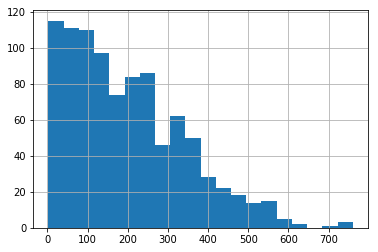

In [123]:
X_rez['Sum_err'].hist(bins=20)

In [187]:
X_rez[X_rez['Sum_err'] > 400].describe()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)","(Ymin, median)","(Xmax, min)","(Xmax, max)","(Xmax, mean)","(Xmax, std)","(Xmax, median)","(Ymax, min)","(Ymax, max)","(Ymax, mean)","(Ymax, std)","(Ymax, median)","(userId, count)","(userId, sum)",Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou,Volume,Mean_Volume,Min_Volume,X_Y_ratio,X_length,Y_length,Diag_length,Xmin_pred,Ymin_pred,Xmax_pred,Ymax_pred,Xmin_diff,Ymin_diff,Xmax_diff,Ymax_diff,Sum_err
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.00000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,16578.989130,71.108696,253.826087,143.413554,72.359521,127.331522,465.630435,573.934783,515.741201,41.710399,512.559783,610.500000,807.728261,726.677539,80.236834,738.739130,914.565217,1096.750000,1031.941347,72.813650,1049.559783,5.652174,4916.065217,149.880435,510.554348,735.913043,1052.869565,0.443496,473426.108696,311002.056403,162426.48913,1.190172,736.619565,631.119565,975.956968,84.136254,474.849130,794.926043,1073.919326,65.744181,35.705217,-59.013000,-21.049761,495.452587
std,10788.771596,53.452342,162.248596,70.739208,62.266970,72.290025,226.548431,246.776484,235.684280,26.840023,237.035745,183.319783,146.331184,139.677679,70.558116,151.727588,268.943938,252.484212,245.995765,65.033627,248.604996,2.535180,2223.799742,122.450155,247.077083,183.512053,271.841228,0.095298,163715.724856,132657.206093,136166.58728,0.245431,156.463726,130.237217,172.463778,42.836281,225.766977,132.439369,251.393073,125.179915,88.675243,174.443503,165.233523,77.918887
min,78.000000,11.000000,32.000000,21.666667,9.073772,22.000000,40.000000,62.000000,54.000000,4.163332,60.000000,102.000000,377.000000,260.100000,6.506407,251.000000,300.000000,528.000000,478.000000,4.098780,502.000000,3.000000,952.000000,0.000000,80.000000,230.000000,517.000000,0.124629,155600.000000,46256.765625,55.00000,0.467742,348.000000,389.000000,557.961468,29.007333,70.957333,384.160000,525.496000,-149.755333,-167.410667,-318.729333,-424.195000,400.092667
25%,7780.250000,34.750000,131.000000,87.075000,31.632695,73.375000,304.000000,392.500000,351.250000,21.474548,331.125000,490.500000,697.250000,628.608333,31.639807,627.500000,712.500000,903.500000,855.333333,32.710853,856.500000,3.000000,3134.500000,25.750000,299.250000,623.500000,859.250000,0.405372,354157.000000,206346.988445,36858.25000,1.018394,609.750000,532.250000,858.343601,55.003000,312.227667,710.001333,885.163000,-43.942833,-35.011833,-207.504667,-129.560000,441.634583
50%,15966.500000,54.000000,214.000000,135.900000,50.980758,108.500000,457.000000,566.500000,505.083333,36.895838,505.750000,626.500000,856.000000,733.500000,61.285402,763.500000,908.000000,1109.500000,1061.225000,55.670103,1077.000000,5.000000,4756.000000,136.500000,479.000000,709.000000,1052.500000,0.452939,463620.000000,310131.657143,138188.50000,1.244195,756.500000,617.000000,978.895671,73.886333,465.490333,833.597667,1077.776500,63.569333,38.822000,-126.751333,-50.840500,472.438167
75%,25601.250000,98.000000,309.500000,197.416667,92.488382,176.250000,629.000000,765.500000,680.937500,57.551668,676.875000,770.000000,922.250000,841.341667,106.037254,862.500000,1093.750000,1282.250000,1195.750000,92.912805,1230.125000,8.000000,6412.500000,256.500000,704.000000,884.500000,1228.750000,0.504503,575416.500000,384571.745313,250841.50000,1.383651,864.750000,692.500000,1104.202850,105.131500,633.054000,892.908500,1216.340250,167.842167,99.522500,68.761333,84.441500,540.064917
max,35962.000000,276.000000,965.000000,339.750000,371.037869,332.000000,1103.000000,1230.000000,1169.20000

In [188]:
X_rez[X_rez['Sum_err'] <= 400].describe()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)","(Ymin, median)","(Xmax, min)","(Xmax, max)","(Xmax, mean)","(Xmax, std)","(Xmax, median)","(Ymax, min)","(Ymax, max)","(Ymax, mean)","(Ymax, std)","(Ymax, median)","(userId, count)","(userId, sum)",Xmin_true,Ymin_true,Xmax_true,Ymax_true,iou,Volume,Mean_Volume,Min_Volume,X_Y_ratio,X_length,Y_length,Diag_length,Xmin_pred,Ymin_pred,Xmax_pred,Ymax_pred,Xmin_diff,Ymin_diff,Xmax_diff,Ymax_diff,Sum_err
count,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000,851.000000
mean,18444.216216,66.534665,166.007051,108.841279,39.289547,103.866627,633.493537,695.002350,659.021465,24.120215,655.670388,341.276146,448.618096,405.607253,42.723143,413.399530,853.764982,947.203290,912.343477,37.199561,921.186251,5.660400,5034.142186,75.822562,639.567568,438.094007,934.291422,0.598078,163025.482961,104267.864459,53868.364277,1.261950,382.083431,313.709753,497.714970,71.718363,636.519542,443.196271,941.107922,4.104198,3.048025,-5.102264,-6.816501,166.721207
std,10369.506866,54.294531,134.794903,77.570354,46.088759,80.343191,258.446041,258.735954,255.931730,28.999325,256.959558,211.323694,252.402696,229.616774,47.198663,235.802285,268.068953,273.534361,266.067956,41.711548,268.626777,2.698334,2628.732357,64.505870,257.963634,255.172483,284.481100,0.139015,166345.997999,113642.697043,82668.424429,0.297542,239.905033,198.965044,306.298834,47.001061,257.040340,247.533569,273.061799,58.191682,44.823786,70.502617,69.973267,108.954869
min,5.000000,-4.000000,20.000000,16.666667,0.000000,15.000000,48.000000,75.000000,71.666667,0.000000,74.000000,14.000000,36.000000,35.666667,0.000000,36.000000,188.000000,383.000000,379.333333,0.000000,379.000000,3.000000,335.000000,-1.000000,21.000000,37.000000,389.000000,-0.000000,0.000000,0.000000,0.000000,0.544413,0.000000,0.000000,0.000000,9.442667,58.866667,36.849333,381.883000,-249.071333,-183.188000,-238.752000,-264.306000,2.218667
25%,9460.500000,33.000000,70.000000,54.100000,10.299523,50.250000,449.000000,497.500000,474.516667,6.083904,472.500000,163.500000,237.000000,214.500000,11.515889,213.500000,643.000000,730.000000,701.277778,9.351693,710.000000,3.000000,2963.500000,32.000000,456.000000,233.000000,710.000000,0.517696,29916.000000,16946.319444,2389.000000,1.067341,185.000000,152.500000,250.429630,43.112333,452.986667,237.463333,723.024500,-25.700333,-15.560333,-39.411667,-38.583000,72.712833
50%,18994.000000,48.000000,124.000000,84.000000,24.924648,77.000000,624.000000,697.000000,656.333333,15.943477,653.000000,318.000000,424.000000,379.800000,27.196814,386.000000,837.000000,928.000000,894.222222,24.260393,905.000000,5.000000,4571.000000,53.000000,636.000000,400.000000,918.000000,0.593580,106145.000000,65421.960000,16647.000000,1.281124,360.000000,293.000000,472.410838,56.709333,626.743333,423.876667,920.027000,-2.102000,-0.878667,1.104000,-2.867000,152.020333
75%,27483.000000,80.000000,215.500000,139.125000,48.308180,129.000000,809.500000,867.000000,832.500000,32.710317,831.000000,488.500000,638.000000,572.920635,55.149187,580.000000,1047.000000,1139.500000,1104.300000,49.079513,1106.000000,7.500000,6521.500000,101.000000,817.500000,626.500000,1120.000000,0.689115,246672.000000,156410.722222,66342.500000,1.444967,555.000000,449.500000,716.212802,82.151667,813.173000,632.524000,1131.456500,30.275333,19.356333,26.386333,18.746500,249.395500
max,35873.000000,442.000000,921.000000,533.000000,359.417584,556.500000,1508.000000,1532.000000,1518.000000,279.762399,151

### Feature importances

In [120]:
# model_Xmin_fitted = model_Xmin.fit(train_data, Xmin_dtarg)

In [121]:
# feat_emp = pd.Series(dict(zip(train_data.columns, model_Xmin_fitted.feature_importances_))).sort_values(ascending=False)

### Train models on whole data

In [124]:
model_Xmin = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Xmin_dtarg)

model_Ymin = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Ymin_dtarg)

model_Xmax = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Xmax_dtarg)

model_Ymax = RandomForestRegressor(n_estimators=500, random_state=65).fit(train_data, Ymax_dtarg)

In [145]:
train_data.head()

,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)","(Ymin, median)","(Xmax, min)","(Xmax, max)","(Xmax, mean)","(Xmax, std)","(Xmax, median)","(Ymax, min)","(Ymax, max)","(Ymax, mean)","(Ymax, std)","(Ymax, median)","(userXmin0, max)","(userXmin-1, max)","(userYmin0, max)","(userYmin-1, max)","(userXmax0, max)","(userXmax-1, max)","(userYmax0, max)","(userYmax-1, max)","(userId, count)",Volume,Mean_Volume,Min_Volume,X_Y_ratio,X_length,Y_length,Diag_length
0,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,917.0,483,511,501.333333,15.885003,510.0,1160,1331,1248.666667,85.675745,1255.0,903,141,1723,141,903,141,1723,903,3,150120,104610.000000,64155,0.863309,360,417,550.898357
1,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,559.0,402,427,416.333333,12.897028,420.0,852,858,855.333333,3.055050,856.0,903,1723,141,903,141,1723,903,141,3,106145,96189.777778,86292,1.187291,355,299,464.140065
2,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,603.0,561,621,596.666667,31.564748,608.0,950,981,966.666667,15.631165,969.0,141,903,141,1723,141,1723,1723,903,3,219075,191652.333333,160648,1.509186,575,381,689.772426
3,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,367.0,97,324,269.200000,97.497179,316.0,369,491,459.200000,51.363411,477.0,1565,1573,903,1565,1565,141,1508,141,5,35742,16642.080000,162,1.876812,259,138,293.470612
4,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,560.0,126,388,256.166667,141.158658,254.0,624,884,756.833333,137.917971,759.5,366,141,141,903,141,903,366,141,6,229295,45790.000000,15540,0.626446,379,605,713.908958


In [144]:
X_test.head()

Xmin                                    Ymin                    \
        min  max        mean        std median  min   max        mean   
itemId                                                                  
18      126  144  135.000000  12.727922  135.0  634   774  704.000000   
19       27   34   29.666667   3.785939   28.0  559   564  560.666667   
33       21   75   46.333333  27.153882   43.0  380   413  393.666667   
62       35  125   90.857143  30.514633   98.0  824  1054  964.857143   
114      41   80   63.333333  20.108042   69.0  570   580  575.000000   

                         Xmax                                      Ymax        \
              std median  min  max        mean         std median   min   max   
itemId                                                                          
18      98.994949  704.0  694  764  729.000000   49.497475  729.0  1010  1132   
19       2.886751  559.0  112  119  114.666667    3.785939  113.0   721   729   
33      17.214335  388.0  345  414  374.666667   35.501174  365.0   620   652   
62      69.681247  980.0  265  639  564.000000  134.809742  623.0  1071  1262   
114      5.000000  575.0  197  216  207.666667    9.712535  210.0   758   780   

                                       userXmin0 userXmin-1 userYmin0  \
               mean        std  median       max        max       max   
itemId                                                                  
18      1071.000000  86.267027  1071.0       903       1723      1723   
19       725.666667   4.163332   727.0      1723        141       903   
33       633.666667  16.502525   629.0       366        141       366   
62      1167.571429  78.089387  1163.0       366        141       366   
114      767.000000  11.532563   763.0      1383       1134      1134   

       userYmin-1 userXmax0 userXmax-1 userYmax0 userYmax-1 userId  Volume  \
              max       max        max       max        max  count           
itemId                                                                       
18            903      1723        903      1723        903      2  317724   
19            141       141       1723       141        903      3   15640   
33            141       366        141       366        141      3  106896   
62           1508      1565       1573       366       1573      7  264552   
114          1383      1195       1383      1383       1195      3   36750   

          Mean_Volume Min_Volume X_Y_ratio X_length Y_length Diag_length  
                                                                          
itemId                                                                    
18      217998.000000     129800  1.281124      638      498  809.350357  
19       14025.000000      12246  0.541176       92      170  193.297698  
33       78800.000000      55890  1.444853      393      272  477.946650  
62       95912.816327       2380  1.378995      604      438  746.096509  
114      27712.000000      20826  0.833333      175      210  273.358739

## Train filter model

In [90]:
model_Xmin = model_Xmin.fit(train_data, Xmin_dtarg)

model_Ymin = model_Ymin.fit(train_data, Ymin_dtarg)

model_Xmax = model_Xmax.fit(train_data, Xmax_dtarg)

model_Ymax = model_Ymax.fit(train_data, Ymax_dtarg)

## Train catboost

In [134]:
model_Xmin = cat_model.fit(train_data, Xmin_dtarg)

model_Ymin = cat_model.fit(train_data, Ymin_dtarg)

model_Xmax = cat_model.fit(train_data, Xmax_dtarg)

model_Ymax = cat_model.fit(train_data, Ymax_dtarg)

## Test dataset preparation

In [135]:
df_test = getminids(df_test)

HBox(children=(IntProgress(value=0, max=630), HTML(value='')))

In [136]:
# with open('df_test.pickle', 'wb') as F:
#     pickle.dump(df_test, F)

In [137]:
X_test = df_test.groupby('itemId').agg({'Xmin': [min, max, 'mean', 'std', 'median'],
                                           'Ymin': [min, max, 'mean', 'std', 'median'],
                                           'Xmax': [min, max, 'mean', 'std', 'median'],
                                           'Ymax': [min, max, 'mean', 'std', 'median'],
#                                            'Xmin0': [max],
#                                            'Xmin-1': [max],
                                           
#                                            'Ymin0': [max],
#                                            'Ymin-1': [max],
                                           
# #                                            'Xmax0': [max],
#                                            'Xmax-1': [max],
                                           
#                                            'Ymax0': [max],
#                                            'Ymax-1': [max],
                                           
                                           'userXmin0': [max],
                                           'userXmin-1': [max],
                                           
                                           'userYmin0': [max],
                                           'userYmin-1': [max],
                                           
                                           'userXmax0': [max],
                                           'userXmax-1': [max],
                                           
                                           'userYmax0': [max],
                                           'userYmax-1': [max],
#                                            'Xmin_id': 'max',
#                                            'Ymin_id': 'max',
#                                            'Xmax_id': 'max',
#                                            'Ymax_id': 'max',
                                           'userId': ['count']})

In [138]:
X_test['Volume'] = (X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')]) *\
                    (X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')])
    
X_test['Mean_Volume'] = (X_test[('Xmax', 'mean')] - X_test[('Xmin', 'mean')]) *\
                (X_test[('Ymax', 'mean')] - X_test[('Ymin', 'mean')])
    
X_test['Min_Volume'] = abs((X_test[('Xmax', 'min')] - X_test[('Xmin', 'max')]) *\
                    (X_test[('Ymax', 'min')] - X_test[('Ymin', 'max')]))
    
    
X_test['X_Y_ratio'] = (X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')])/\
                            (X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')])    
    
X_test['X_length'] = X_test[('Xmax', 'max')] - X_test[('Xmin', 'min')]
X_test['Y_length'] = X_test[('Ymax', 'max')] - X_test[('Ymin', 'min')]

X_test['Diag_length'] = np.sqrt(X_test['X_length']**2 + X_test['Y_length']**2)

In [139]:
X_test['X_Y_ratio'] = X_test['X_Y_ratio'].replace(np.inf, 2)
X_test.fillna(1, inplace=True)

In [146]:
preds_Xmin = model_Xmin.predict(X_test.values)
preds_Ymin = model_Ymin.predict(X_test.values)
preds_Xmax = model_Xmax.predict(X_test.values)
preds_Ymax = model_Ymax.predict(X_test.values)

In [147]:
X_test['Xmin_pred'] = X_test[('Xmin', 'min')] + preds_Xmin/1
X_test['Ymin_pred'] = X_test[('Ymin', 'min')] + preds_Ymin/1
X_test['Xmax_pred'] = X_test[('Xmax', 'max')] + preds_Xmax/1
X_test['Ymax_pred'] = X_test[('Ymax', 'max')] + preds_Ymax/1

In [148]:
X_test['itemId'] = X_test.index
X_test = X_test[['itemId', 'Xmin_pred', 'Ymin_pred', 'Xmax_pred', 'Ymax_pred']]

In [149]:
X_test.to_csv('../Submits/submit22.csv', header=False, index=False)

In [150]:
X_pred.head()

,itemId,"(Xmin, min)","(Xmin, max)","(Xmin, mean)","(Xmin, std)","(Xmin, median)","(Ymin, min)","(Ymin, max)","(Ymin, mean)","(Ymin, std)","(Ymin, median)","(Xmax, min)","(Xmax, max)","(Xmax, mean)","(Xmax, std)","(Xmax, median)","(Ymax, min)","(Ymax, max)","(Ymax, mean)","(Ymax, std)","(Ymax, median)","(userXmin0, max)","(userXmin-1, max)","(userYmin0, max)","(userYmin-1, max)","(userXmax0, max)","(userXmax-1, max)","(userYmax0, max)","(userYmax-1, max)","(userId, count)",Xmin_true,Ymin_true,Xmax_true,Ymax_true,Volume,Mean_Volume,Min_Volume,X_Y_ratio,X_length,Y_length,Diag_length
0,5,151,210,184.333333,30.237945,192.0,914,925,918.666667,5.686241,917.0,483,511,501.333333,15.885003,510.0,1160,1331,1248.666667,85.675745,1255.0,903,141,1723,141,903,141,1723,903,3,198,827,649,1340,150120,104610.000000,64155,0.863309,360,417,550.898357
1,10,72,96,87.666667,13.576941,95.0,559,570,562.666667,6.350853,559.0,402,427,416.333333,12.897028,420.0,852,858,855.333333,3.055050,856.0,903,1723,141,903,141,1723,903,141,3,26,605,433,847,106145,96189.777778,86292,1.187291,355,299,464.140065
2,13,46,94,69.666667,24.006943,69.0,600,606,603.000000,3.000000,603.0,561,621,596.666667,31.564748,608.0,950,981,966.666667,15.631165,969.0,141,903,141,1723,141,1723,1723,903,3,233,698,622,920,219075,191652.333333,160648,1.509186,575,381,689.772426
3,30,65,124,91.400000,21.454603,87.0,353,375,365.600000,9.528903,367.0,97,324,269.200000,97.497179,316.0,369,491,459.200000,51.363411,477.0,1565,1573,903,1565,1565,141,1508,141,5,61,368,329,530,35742,16642.080000,162,1.876812,259,138,293.470612
4,32,9,42,28.166667,14.260669,30.0,279,809,556.000000,273.930648,560.0,126,388,256.166667,141.158658,254.0,624,884,756.833333,137.917971,759.5,366,141,141,903,141,903,366,141,6,30,536,328,813,229295,45790.000000,15540,0.626446,379,605,713.908958


In [133]:
X_test.head( )

,itemId,Xmin_pred,Ymin_pred,Xmax_pred,Ymax_pred
,,,,,
itemId,,,,,
18,18,122.493333,631.728000,765.872667,1141.791
19,19,29.498667,563.654667,123.372000,724.349
33,33,28.682000,382.785333,406.091333,651.389
62,62,51.265333,829.119333,629.235333,1259.410
114,114,43.971333,571.029333,221.497333,757.308


## Test prediction

In [46]:
test_pred = df_test.groupby('itemId').agg({'Xmin': min,
                                              'Ymin': min,
                                              'Xmax': max,
                                              'Ymax': max})

In [47]:
test_pred['itemId'] = test_pred.index
test_pred = test_pred[['itemId', 'Xmin', 'Ymin', 'Xmax', 'Ymax']]

In [30]:
test_pred.to_csv('../Submits/submit3.csv', header=False, index=False)

In [31]:
test_pred

,itemId,Xmin,Ymin,Xmax,Ymax
itemId,,,,,
18,18,126,634,764,1132
19,19,27,559,119,729
33,33,21,380,414,652
62,62,35,824,639,1262
114,114,41,570,216,780
146,146,17,211,643,1118
156,156,74,802,160,887
163,163,21,317,213,465
164,164,4,146,401,681
